In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [68]:
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader

from src.model import get_model, encode_fixing
from src.net import ObjSurrogate
from src.dataset import EarlyFixingDataset

In [3]:
with open('../ef_objs.pkl', 'rb') as f:
    ef_objs = pickle.load(f)

ef_objs.keys()

dict_keys(['JUB-48', 'JUB-55', 'JUB-58'])

In [4]:
X = list()
y = list()
for n in ef_objs.keys():
    for c1, c2, gl1, gl2 in ef_objs[n].keys():
        c_pair = (c1, c2)
        gl_pair = (gl1, gl2)

        c_mbd, gl_mbd = encode_fixing(c_pair, gl_pair, n)

        X.append((n, c_mbd, gl_mbd))
        y.append(ef_objs[n][c1, c2, gl1, gl2])

In [27]:
well, c_mbd, gl_mbd = X[0]

model = get_model([well,])

A = model.getA().toarray()
b = np.array(model.getAttr('rhs'))


A = torch.from_numpy(A).unsqueeze(0)
b = torch.from_numpy(b).unsqueeze(0)
z_c = torch.from_numpy(c_mbd).unsqueeze(0)
z_gl = torch.from_numpy(gl_mbd).unsqueeze(0)

torch.hstack([A.flatten(1), b, z_c, z_gl]).dtype

Set parameter IntFeasTol to value 1e-09


torch.float64

In [32]:
net = ObjSurrogate().double()

net(A, b, z_c, z_gl)

tensor([[4342115.8560]], dtype=torch.float64, grad_fn=<AddmmBackward0>)

# Train

device(type='cuda', index=0)

Set parameter IntFeasTol to value 1e-09
Set parameter IntFeasTol to value 1e-09
Set parameter IntFeasTol to value 1e-09


  0%|          | 0/10000 [00:00<?, ?it/s]

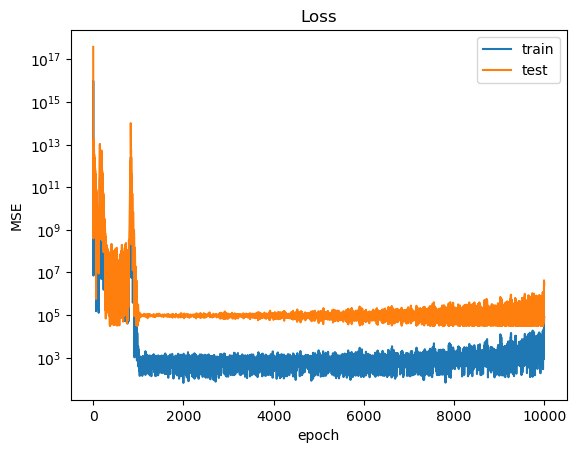

In [86]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

net = ObjSurrogate(layers=[1000, 100, 10, 1]).double().to(device)

opt = torch.optim.Adam(net.parameters(), lr=.01)
loss_fun = torch.nn.MSELoss()

ef_objs_train = ef_objs.copy()
ef_objs_train.pop('JUB-58', None)

ds_train = EarlyFixingDataset(ef_objs_train)

ef_objs_test = ef_objs.copy()
ef_objs_test.pop('JUB-48', None)
ef_objs_test.pop('JUB-55', None)

ds_test = EarlyFixingDataset(ef_objs_test)

dl_train = DataLoader(ds_train, 2**4, shuffle=True)
dl_test = DataLoader(ds_test, 2**4)

train_losses = list()
test_losses = list()
for _ in tqdm(list(range(10000))):
    net.train()
    train_loss = 0
    for (A, b, z_c, z_gl), y in dl_train:

        y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

        loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss += loss.item() / len(y)
        break
    train_losses.append(train_loss / len(dl_train))

    net.eval()
    test_loss = 0
    for (A, b, z_c, z_gl), y in dl_test:
        with torch.no_grad():
            y_hat = net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

            loss = loss_fun(y_hat, y.unsqueeze(-1).double().to(device))

        test_loss += loss.item() / len(y)
    test_losses.append(test_loss / len(dl_test))

plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.title('Loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.yscale('log')
plt.show()

In [85]:
(A, b, z_c, z_gl), y = next(iter(dl_train))

net(A.to(device), b.to(device), z_c.to(device), z_gl.to(device))

tensor([[-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846],
        [-0.0846]], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddmmBackward0>)